In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, trange

In [8]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Linear(2, 3),
            nn.ReLU(),
            nn.Linear(3, 2),
        )
        self.w = nn.Linear(2, 1)
    
    def forward(self, inputs):
        z = self.feature_extractor(inputs)
        outputs = torch.sigmoid(self.w(z))
        return outputs


In [9]:
def train(model, optimizer, loss_fxn, dataset, nsteps=10000):
    xtest, ytest = dataset.sample(1000)
    plt.scatter(xtest[:, 0], xtest[:, 1], c=ytest)
    plt.show()

    losses = []
    accur = []
    with trange(nsteps) as t:
        for i in t:
            x, y = dataset.sample(256)
            output = model(x)
            loss = loss_fxn(output, y)

            # accuracy
            predicted = model(xtest)
            acc = (predicted.reshape(-1).detach().numpy().round() == ytest.reshape(-1).detach().numpy()).mean()

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if i % 50 == 0:
                losses.append(loss)
                accur.append(acc)
                t.set_description("loss : {:.3f}\t accuracy : {:.2f}".format(loss, acc))

    ztest = model.feature_extractor(xtest).detach().numpy()
    ytest = ytest.detach().numpy()
    plt.scatter(
        *(ztest + 0.05 * np.random.randn(*ztest.shape)).T, c=ytest,
        alpha=0.5, s=3
    )
    return ztest, ytest

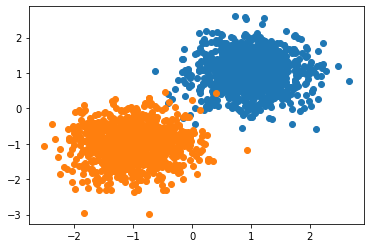

In [10]:
plt.scatter(*(.5 * np.random.randn(1000, 2) - np.array([-1, -1])).T)
plt.scatter(*(.5 * np.random.randn(1000, 2) - np.array([1, 1])).T)

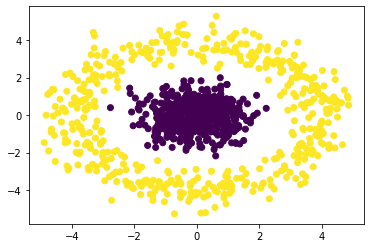

In [11]:
class CircleSampler:
    def __init__(self):
        self.radii = np.array([1, 4])

    def sample(self, nsamples):
        y = np.random.choice(len(self.radii), size=nsamples)
        r = self.radii[y] + .5 * np.random.randn(nsamples)
        theta = 2 * np.pi * np.random.random(nsamples)
        x = np.vstack((
            r * np.cos(theta),
            r * np.sin(theta)
        )).T
        return torch.Tensor(x), torch.Tensor(y).reshape(-1, 1)
    
x, y = CircleSampler().sample(1000)
plt.scatter(*x.T, c=y)

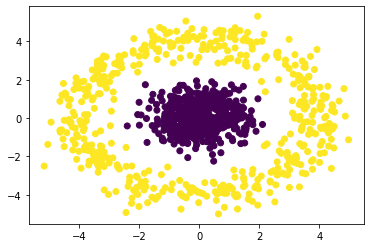

loss : 0.007	 accuracy : 1.00: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:09<00:00, 1001.44it/s]


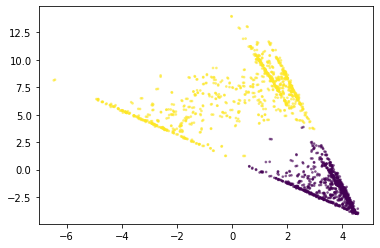

In [12]:
model = Net()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

z, y = train(
    model=model, optimizer=optimizer,
    loss_fxn=nn.BCELoss(),
    dataset=CircleSampler()
)

plt.scatter(
    z[:, 0], z[:, 1], c=y,
    alpha=0.5, s=3
)

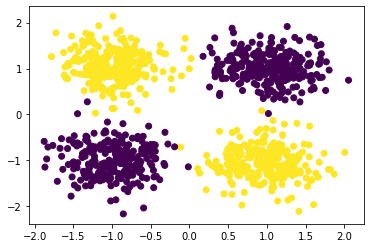

In [13]:
class XORSampler:
    def __init__(self):
        self.loc_centers = np.array([
            [1, 1],
            [-1, 1],
            [-1, -1],
            [1, -1]
        ])
        
    def sample(self, nsamples):
        x = .35 * np.random.randn(nsamples, 2)
        centers = np.random.randint(4, size=nsamples)
        y = centers % 2

        x = x + self.loc_centers[centers]
        return torch.Tensor(x), torch.Tensor(y).reshape(-1, 1)


x, y = XORSampler().sample(1000)
plt.scatter(*x.T, c=y)

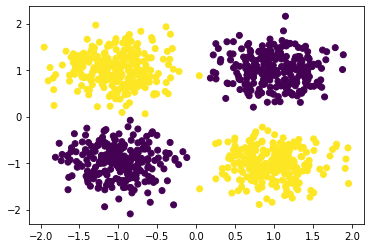

loss : 0.358	 accuracy : 0.74: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:10<00:00, 983.86it/s]


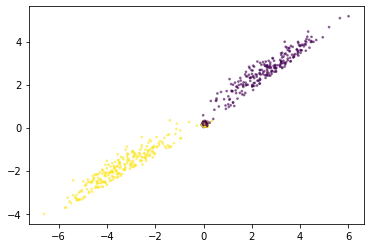

In [14]:
model = Net()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

z, y = train(
    model=model, optimizer=optimizer,
    loss_fxn=nn.BCELoss(),
    dataset=XORSampler()
)